# Multi Vehicle Routing (16.413/6.877 course project)

**Introduction to Multiple Vehicle Routing**

The team of diagnosis droids needs to be deployed to make observations on the workstations to exactly determine the faulty components. We are tasked with assigning the order in which workstations are visited by our fleet of droids to minimize the time required by our plan.


This can be thought of as a multiple vehicle routing problem - "Given a list of locations and the distances between them, and a fleet of vehicles, what is the lowest cost set of possible routes that visits each location exactly once and returns to the original location?"

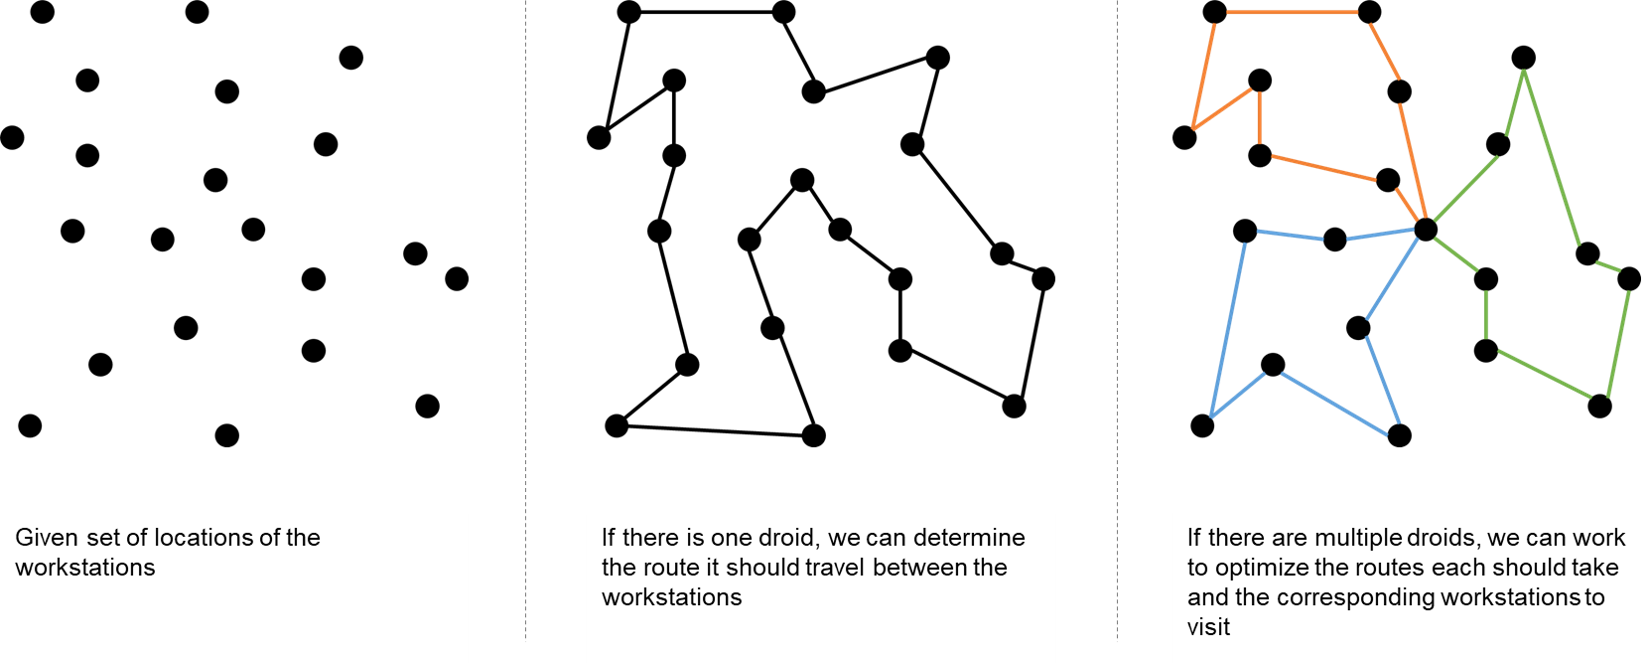

**Constraint Satisfaction Problem Background**

Constraint satisfaction problems have three components:
1. A set of variables
2. A set of domains for each variable
3. A set of constraints specifying allowable combinations

Solutions can be determined using constraint propagation, eliminating values from domains that won’t be part of a solution, and search, exploring the costs of committing to specific assignments.

Our definition of this constraint satisfaction problems is as follows:
* Variables – {Workstations}
* Domain – {Droids}
* Constraints
 * Minimize overall droid travel time
 * Each workstation must be visited by at least one droid
 * Droids must start and end at depot

For each workstation, we know how much time it takes to make the observations required and the time/distance to travel to every other workstation. We know how many droids we have and know we want to minimize the amount of time required to complete the observations. There is also a depot location where the droids need to start and end their route. We need to determine the route each droid should take to minimize the total time required. Given the number of workstations w and the number of droids d, the number of possible state assignments would be d^w. As the number of droids and workstations increase, the problem becomes NP Hard. 

**NEED TO DETERMINE WHERE TO GO FROM HERE**

potential ideas
* simulated annealing overview
* Golden paper method overview
* whatever way MiniZinc uses

**OLD-- Golden Paper Background**
* If keeping this, need to add description of tabu search per Charles' comments

The method we plan to demonstrate to solve this problem is described in “An Adaptive Memory Heuristic for a Class of Vehicle Routing Problems with Minmax Objective” by Golden et al. - a tabu search based heuristic for a minmax vehicle routing problem. Tabu search uses a local search to iteratively move from one potential solution to an improved solution. 

1. A partial initial solution containing up to m feasible routes is proposed for our environment. It could contain unserviced workstations, but we could assign a high cost to unserviced workstations to make solutions that service all workstations more favorable. The cost of this route is calculated and used as a constraint for new routes that will be created during the course of the algorithm.
2. The problem is decomposed into several subproblems to construct new routes and a locally optimal solution is determined for each subproblem. This is done via a search and utilizing one of the following operations (similar to what would be done in a genetic algorithm):
 * swapping customers between different routes
 * moving a customer to a different route
 * inserting an customer into a route
 * removing a customer from a route

 The minimum cost route is then recorded and set as the new constraint.
3. At set intervals, the decomposition of new subproblems is done until the process ends after a set number of iterations. 




**Googledoc link**
Link to my edits to text document: https://docs.google.com/document/d/1erjKy4EParSTpvh_4yV5FFI5dJq7n7SsHHq6Mrpjaww/edit


In [ ]:
# TODO: @nsidn98 setup the environment/ define the network/graph
import math
import numpy as np

class Depot:
    def __init__(self, depot_id:int, x:int, y:int, service_time:int, is_serviced:bool=False):
        """
            Definition of each depot
            params:
                depot_id: int
                    The index of the depot
                    Example : 10
                x: int
                    The x co-oordinate of the depot in the 2D plane
                    Example: 0
                y: int
                    The y co-oordinate of the depot in the 2D plane
                    Example: 0
                service_time: int
                    The amount of time spent at this depot to make repairs
                    Example : 13
                is_serviced: bool
                    To track whether it has been repaired or not
                    Set it to True if no repair is needed
                    Default is set to False, so all depots require repair by default
        """
        self.depot_id = depot_id
        self.x = x
        self.y = y
        self.service_time = service_time
        self.is_serviced = is_serviced    # boolean to track whether depot has been repaired
    
    def __repr__(self):
        """
            Representation of the class.
            Usage:
                depot = Depot(10,0,0,13)
                print(depot)
        """
        return f"Depot ID: {self.depot_id}\n"\
               f"Co-ordinates: {self.x, self.y}\n"\
               f"Repair time: {self.service_time}\n"\
               f"Does depot need repair?: {not self.is_serviced}"

    def distance(self, target:Depot):
        """
            Distance between this depot and the target depot co-ords
            params:
                target: Depot
            usage:
                depot1 = Depot(1,0,0,13)
                depot2 = Depot(2,10,0,10)
                depot12_dist = depot1.distance(depot2)
        """
        return math.sqrt(math.pow(self.x - target.x, 2) + math.pow(target.y - self.y, 2))

class Network:
    def __init__(self, data:np.ndarray):
        """
            Create a 2D network which will have the following:
                * network of depots
                * starting depot of the droids
                * ending depot of the droids (maybe same as start)
            params:
                data: np.ndarray
                2D array which contains the
                [depot-id, coords, service_time, service_requirement]
                as its columns
        """
        self.create_network(data)   # create the network of depots

    def create_network(self, data:np.ndarray):
        """
            Create a network of depots
            params:
                data: np.ndarray
                2D array which contains the
                [depot-id, coords, service_time, service_requirement]
                as its columns
        """
        self.network = {}
        for i in range(len(data)):
            depot_id, x, y, service_time, service_requirement = data[i]
            self.network[str(i)] = Depot(depot_id, x, y, service_time, service_requirement)
        
    def plot(self):
        """
            Plot the 2D network
            Use networkx, shapely and matplotlib to plot the network
        """
        pass


In [ ]:
# TODO: @sjvigil add droid class info
class Droid(object):
    def __init__(self, point, children=None, parent=None):
        self.xy = np.array(point)
        self.parent = parent
        self.children = children if children else []
        
    @property
    def all_descendents(self):
        """Return an iterable of all the descendants from this node (i.e. children + childrens' children + ...)"""
        yield self
        for c in self.children:
            for n in c.all_descendents:
                yield n
    @property
    def point(self):
        return Point(self.xy)
    
    @property
    def all_ancestors(self):
        """Return an iterable of all the ancestors this node (i.e. parent + parent's parent + ...),
        starting from this node."""
        yield self
        if self.parent is not None:
            for a in self.parent.all_ancestors:
                yield a
        
    @property
    def path(self):
        """Returns a path from the start position to this node, expressed as an iterable of tuples of x-y coordinates"""
        path = list(self.all_ancestors)
        for n in reversed(path):
            yield tuple(n.xy)
    
    def __repr__(self):
        return self.xy

In [ ]:
##Didn't do any code for this, just researched some techniques and made some notes we can talk about during the meeitng

def CSP(network, depot, num_droids):
    
    ##Started with a single vehicle problem for modeling, obj function considers the swarm
    
    ##Variables
    next_i = site to visit after site i
    
    ##Domain
    {1, 2, ...n, n+droid_num}  ##n+droid_num is the origin site
     
    ## constraints
    all_visited (is_serviced in Depot class)
    all_different
    path_start = 0, path_end = n+droid_num
    forall i, successor(i) != i
    
    ##Objective 
    minimize max(droid.path for all droids) ##if we stay with Siddarth's notation, droid path should include distance cost and time to repair station
    '''
        To get solutions we can consider an adaptive memory program described in the Golden (1997) paper.
                *Combine the heuristic solutions using probabalistic rules to create new solutions (not dissimilar from genetic)
                
            o General concept is to produce m feasible routes (can have unserviced customers, but they are penalized) 
            o Decompose problem into 1 or more subproblems considering 3-5 vehicle routes
            o Then use a search technique. Tabu search - locally optimum results are found using 4 transformations
            o Use minimax to keep track of your best solution
                o as mentioned in obj function, our consideration will be the length of the longest route
            o Periodically reshuffle subproblems and end after a given number of iterations
    '''
    